In [1]:
import matplotlib.pyplot as plt
import numpy as np
import os
import tensorflow as tf

2022-10-03 15:52:28.973059: W tensorflow/stream_executor/platform/default/dso_loader.cc:64] Could not load dynamic library 'libcudart.so.11.0'; dlerror: libcudart.so.11.0: cannot open shared object file: No such file or directory
2022-10-03 15:52:28.973108: I tensorflow/stream_executor/cuda/cudart_stub.cc:29] Ignore above cudart dlerror if you do not have a GPU set up on your machine.


In [4]:
def moving_average(l, step):
    res = []
    for i in range(1, len(l)-step-1):
        res.append(sum(l[i:i+step]) / step)
    return res

In [5]:
batch_size = 32
img_height = 160
img_width = 160
IMG_SIZE = (img_height, img_width)
data_dir = "../input/stage-1cs-dataset/final_images/"
base_learning_rate = 0.0003

In [6]:
datagen = tf.keras.preprocessing.image.ImageDataGenerator(
    rotation_range=10,
    horizontal_flip=True,
    validation_split=0.2,
    preprocessing_function = tf.keras.applications.mobilenet_v2.preprocess_input
)

train_generator = datagen.flow_from_directory(
    data_dir,
    seed=123,
    target_size=(img_height, img_width),
    batch_size=batch_size,
    class_mode='categorical',
    subset='training') # set as training data

validation_generator = datagen.flow_from_directory(
    data_dir, # same directory as training data
    seed=123,
    target_size=(img_height, img_width),
    batch_size=batch_size,
    class_mode='categorical',
    subset='validation') 

Found 1352 images belonging to 5 classes.
Found 336 images belonging to 5 classes.


In [7]:
def define_model():
    
    IMG_SHAPE = IMG_SIZE + (3,)
    base_model = tf.keras.applications.MobileNetV2(input_shape=IMG_SHAPE,
                                                   include_top=False,
                                                   weights='imagenet')


    global_average_layer = tf.keras.layers.GlobalAveragePooling2D()
    prediction_layer = tf.keras.layers.Dense(5, name="outputs", activation='softmax')
    
    x = base_model.output
    x = global_average_layer(x)
    x = tf.keras.layers.Dropout(0.4)(x)
    outputs = prediction_layer(x)

    model = tf.keras.Model(base_model.input, outputs)
    model.trainable = True
    
    return model

        
def freeze_model(model, layer_num):
    
    init_layer  = ('input_1', 'Conv1', 'bn_Conv1', 'Conv1_relu', 'expanded')
    blocks      = tuple([f'block_{i+1}_' for i in range(min(16, layer_num-1))])
    final_layer = ('Conv_1', 'Conv_1_bn', 'out_relu', 'global_average_pooling2d', 'dropout', 'outputs')
    
    for layer in model.layers:
        if not layer.name.startswith(init_layer[:10*(layer_num>0)] + blocks + final_layer[:10*(layer_num>16)]):
            layer.trainable = True
        else:
            layer.trainable = False

# model = define_model()
# freeze_model(model, 10)

In [9]:
def train_model(model, epochs):
    
    model.compile(
        optimizer=tf.keras.optimizers.Adam(learning_rate=base_learning_rate),
        loss=tf.keras.losses.CategoricalCrossentropy(from_logits=False),
        metrics=['accuracy']
    )

    with tf.device('/GPU:0'):
        history = model.fit(
            train_generator,
            epochs=epochs,
            validation_data=validation_generator,
        )
        
    return history

# Train model :

In [12]:
model = define_model()
freeze_model(model, 10)

history = train_model(model, 100)

Epoch 1/100
43/43 [==============================] - 18s 356ms/step - loss: 0.9404 - accuracy: 0.6679 - val_loss: 2.3287 - val_accuracy: 0.3423
Epoch 2/100
43/43 [==============================] - 12s 290ms/step - loss: 0.3096 - accuracy: 0.8935 - val_loss: 1.6795 - val_accuracy: 0.5060
Epoch 3/100
43/43 [==============================] - 12s 276ms/step - loss: 0.1794 - accuracy: 0.9364 - val_loss: 2.1286 - val_accuracy: 0.4702
Epoch 4/100
43/43 [==============================] - 12s 277ms/step - loss: 0.1337 - accuracy: 0.9556 - val_loss: 3.3688 - val_accuracy: 0.2649
Epoch 5/100
43/43 [==============================] - 12s 284ms/step - loss: 0.0682 - accuracy: 0.9786 - val_loss: 1.9586 - val_accuracy: 0.5446
Epoch 6/100
43/43 [==============================] - 12s 276ms/step - loss: 0.0725 - accuracy: 0.9749 - val_loss: 2.4224 - val_accuracy: 0.4702
Epoch 7/100
43/43 [==============================] - 12s 291ms/step - loss: 0.0604 - accuracy: 0.9778 - val_loss: 1.2745 - val_accuracy:

(0.6, 1.0)

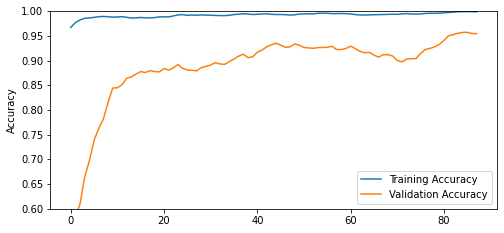

In [18]:
step = 10

acc = moving_average(history.history['accuracy'], step)
val_acc = moving_average(history.history['val_accuracy'], step)

loss = moving_average(history.history['loss'], step)
val_loss = moving_average(history.history['val_loss'], step)

plt.figure(figsize=(8, 8))

plt.subplot(2, 1, 1)
plt.plot(acc, label='Training Accuracy')
plt.plot(val_acc, label='Validation Accuracy')
plt.legend(loc='lower right')
plt.ylabel('Accuracy')
plt.ylim([0.6,1])

In [19]:
model.save('celeb5_model_ft10.tf')

2022-09-20 10:23:25.124407: W tensorflow/python/util/util.cc:348] Sets are not currently considered sequences, but this may change in the future, so consider avoiding using them.
/opt/conda/lib/python3.7/site-packages/keras/utils/generic_utils.py:497: CustomMaskWarning: Custom mask layers require a config and must override get_config. When loading, the custom mask layer must be passed to the custom_objects argument.
  category=CustomMaskWarning)


# Try different frozen parts :

In [ ]:
block_history_dict = {}

for block_num in list(range(0, 17, 3)) + [17]:
    
    print(f'[INFO] Freezing the model before the block : {block_num} '+'-'*100)
    
    model = define_model()
    freeze_model(model, layer_num)
    
    history = train_model(model, 30)
    
    block_history_dict[ block_num ] = history
    

[INFO] Freezing the model before the block : 0 ----------------------------------------------------------------------------------------------------


2022-09-19 20:48:13.780222: I tensorflow/compiler/mlir/mlir_graph_optimization_pass.cc:185] None of the MLIR Optimization Passes are enabled (registered 2)


Epoch 1/30


2022-09-19 20:48:18.905084: I tensorflow/stream_executor/cuda/cuda_dnn.cc:369] Loaded cuDNN version 8005


43/43 [==============================] - 29s 425ms/step - loss: 1.0352 - accuracy: 0.6191 - val_loss: 2.0358 - val_accuracy: 0.5208
Epoch 2/30
43/43 [==============================] - 13s 313ms/step - loss: 0.3641 - accuracy: 0.8728 - val_loss: 1.5701 - val_accuracy: 0.6518
Epoch 3/30
43/43 [==============================] - 13s 306ms/step - loss: 0.2388 - accuracy: 0.9135 - val_loss: 1.8208 - val_accuracy: 0.6429
Epoch 4/30
43/43 [==============================] - 13s 304ms/step - loss: 0.1594 - accuracy: 0.9460 - val_loss: 1.6394 - val_accuracy: 0.6815
Epoch 5/30
43/43 [==============================] - 14s 327ms/step - loss: 0.1075 - accuracy: 0.9638 - val_loss: 2.3514 - val_accuracy: 0.5952
Epoch 6/30
43/43 [==============================] - 13s 305ms/step - loss: 0.0906 - accuracy: 0.9697 - val_loss: 1.5791 - val_accuracy: 0.6905
Epoch 7/30
43/43 [==============================] - 14s 315ms/step - loss: 0.1060 - accuracy: 0.9586 - val_loss: 2.0780 - val_accuracy: 0.6637
Epoch 8/30

In [147]:
all_history_ = []
for k, history in all_history.items():

    acc = history.history['accuracy']
    val_acc = history.history['val_accuracy']

    loss = history.history['loss']
    val_loss = history.history['val_loss']
    
    all_history_.append([
        acc, val_acc, loss, val_loss
    ])

In [99]:
import pickle

with open('all_history.pkl', 'wb') as file:
    pickle.dump(all_history_, file)

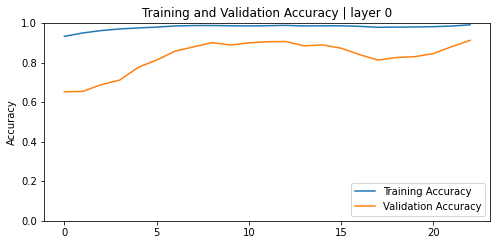

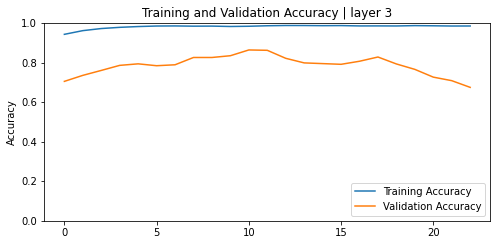

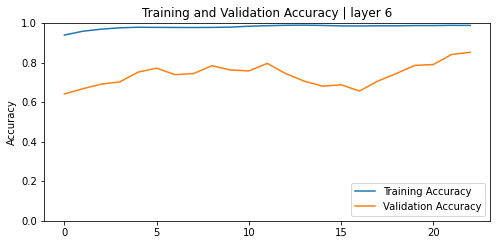

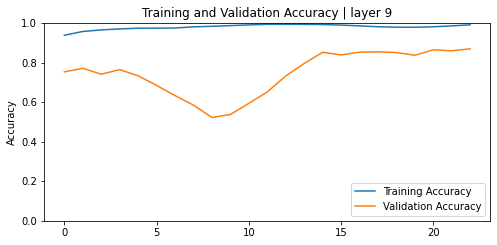

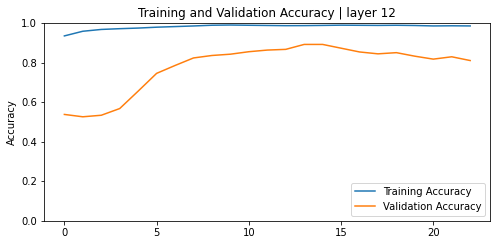

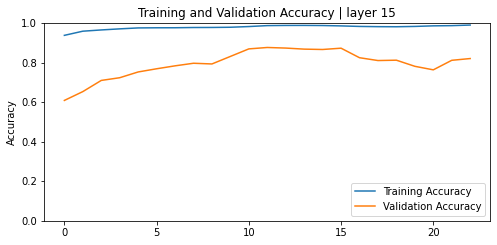

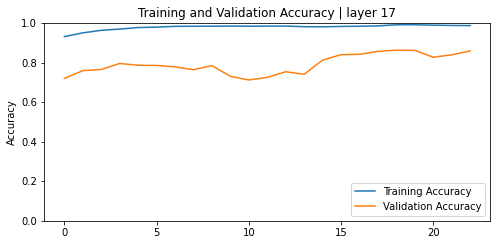

In [26]:
for k, history in block_history_dict.items():

    step = 5
    
    acc = moving_average(history.history['accuracy'], step)
    val_acc = moving_average(history.history['val_accuracy'], step)

    loss = moving_average(history.history['loss'], step)
    val_loss = moving_average(history.history['val_loss'], step)

    plt.figure(figsize=(8, 8))
    
    plt.subplot(2, 1, 1)
    plt.plot(acc, label='Training Accuracy')
    plt.plot(val_acc, label='Validation Accuracy')
    plt.legend(loc='lower right')
    plt.ylabel('Accuracy')
    plt.ylim([0,1])
    plt.title(f'Training and Validation Accuracy | layer {k}')
    

In [ ]:
converter = tf.lite.TFLiteConverter.from_keras_model(model)
tflite_model = converter.convert()
with open('models/finetune_lite_model_celeb5', 'wb') as file:
    file.write(tflite_model)